# Hands-on Neural Network for Classifying Handwritten Digits

The data set we will be using is called [MNIST](http://yann.lecun.com/exdb/mnist/). It was create by Yann Lecun and is considered to be the "hello world" of datasets for deep learning. 

MNIST consists of 28x28 pixel images of hand written digis.

<center> <img src="img/mnist.png" width="300"/>  </center>

<br/>

We are going to create a feed forward neural network to classify the digits. This will be a simple network composed of linear layers and activations.

In [1]:
import torch
import torchvision

import matplotlib.pyplot as plt
%matplotlib inline

## Create Transforms

When we get the dataset, we will be given tuples that look like:

        (PIL image, label)

We will need to apply a transform to each image loaded to convert it to a tensor. This can be done using a library included with Pytorch called TorchVision. This library contains datasets, helper functions, transforms, and even whole neural networks that can all be loaded easily.

We will use the transform `ToTensor()` which will convert each image to a tensor that we can use in our model.

In [2]:
xforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])  # Try with no normalization for now

In [3]:
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=xforms)
test_data = torchvision.datasets.MNIST(root='./data', train=False, transform=xforms)

In [4]:
batch_size=64
train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=1,
                                          shuffle=True)

## Lets take a look at the data

Pytorch data loaders are a convenient way to get tensors into your model with very little manual work. Custom datasets are very easy to define if you are using data that doesnt fit well into one of the predefined classes.

The dataloaders defined above work just like an iterator. We can get an item from it by calling `next(iter(loader))`. When accessing all of the data we simply have to loop over the dataloader `for data, label in dataloader:`.

Lets take a look at how the dataloader returns data to us. For the MNIST dataset (and most imagery data) it returns a tuple where the first element is a  tensor with the shape [batch, channels, height, width], and the second element is the label (in this case an integer).

In [5]:
d = next(iter(train_loader))
print(d[0].shape) # the data
print(d[1].shape) # the labels

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [6]:
d[1]

tensor([7, 8, 8, 3, 4, 6, 8, 1, 9, 8, 1, 9, 8, 9, 5, 4, 3, 2, 8, 8, 7, 4, 4, 9,
        4, 8, 1, 1, 9, 8, 7, 2, 5, 8, 2, 9, 5, 9, 0, 7, 4, 4, 7, 9, 8, 9, 3, 7,
        2, 0, 7, 9, 4, 0, 6, 3, 9, 9, 7, 9, 0, 3, 0, 6])

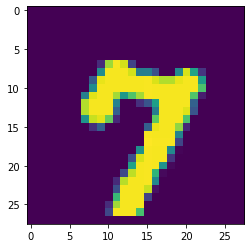

In [7]:
plt.imshow(d[0][0].squeeze().numpy())

## Defining our Classification Model

In [8]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.layers = torch.nn.Sequential(
                            torch.nn.Linear(in_features=784, out_features=128),
                            torch.nn.ReLU(),
                            torch.nn.Linear(in_features=128, out_features=64),
                            torch.nn.ReLU(),
                            torch.nn.Linear(in_features=64, out_features=10),
                            torch.nn.Softmax(dim=1)
                        )
    
    def forward(self, x):
        return self.layers(x)

In [9]:
model = Net()

## Setup the Optimizer

We will be using the Adam optimizer.

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

## Setup the Loss function

For classification problems in general you will use the cross entropy loss.

In [11]:
criterion = torch.nn.CrossEntropyLoss()

## Run the training loop

In [12]:
epochs = 25
loss_history = []
for epoch in range(epochs):
    epoch_loss = 0
    for data, labels in train_loader:
        # Flatten the tensors to go from 28x28 -> 784
        flat_data = data.view(data.shape[0], -1)
        
        optimizer.zero_grad()
        pred = model(flat_data)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss_history.append(epoch_loss/len(train_loader))    
    print(f"Epoch {epoch} - loss: {epoch_loss/len(train_loader)}")

Epoch 0 - loss: 1.5748772943960323
Epoch 1 - loss: 1.5153985130253123
Epoch 2 - loss: 1.5063964771563565
Epoch 3 - loss: 1.5000071858546373
Epoch 4 - loss: 1.4980867296647924
Epoch 5 - loss: 1.496187745253923
Epoch 6 - loss: 1.4945135807940193
Epoch 7 - loss: 1.4962206297337628
Epoch 8 - loss: 1.494236725606898
Epoch 9 - loss: 1.4944588164530836
Epoch 10 - loss: 1.4920548027766538
Epoch 11 - loss: 1.4932545969989508
Epoch 12 - loss: 1.491058767096066
Epoch 13 - loss: 1.4916964136461206
Epoch 14 - loss: 1.4896302983196559


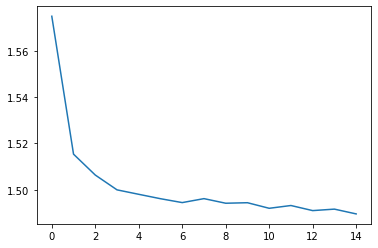

In [13]:
plt.plot(loss_history)

In [14]:
img, label = next(iter(test_loader))

flat_img = img[0].view(1,784)
with torch.no_grad():
    pred = list(model(flat_img).numpy()[0])
    print(f"Actual Class: {label[0].item()}    Predicted Class: {pred.index(max(pred))}")

Actual Class: 7    Predicted Class: 7


In [15]:
correct_count, all_count = 0, 0
for image,label in test_loader:
    img = image.view(1, 784)
    with torch.no_grad():
        prob = list(model(img).numpy()[0])

    pred_label = prob.index(max(prob))
    true_label = label.numpy()
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9668
